In [1]:
import json
import csv

import sys
sys.path.append("../../")
sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

import implicitmodules.torch as dm
from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian

torch.set_default_tensor_type(torch.DoubleTensor)

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/rosa/DefmodEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
with open('../../data/nutsdata.pickle', 'rb') as f:
            lines, sigv, sig = pickle.load(f)

source = torch.tensor(lines[0][::2], requires_grad=True, dtype=torch.float64)[1:]
target = torch.tensor(lines[1][::2]  , requires_grad=True, dtype=torch.float64)[1:]


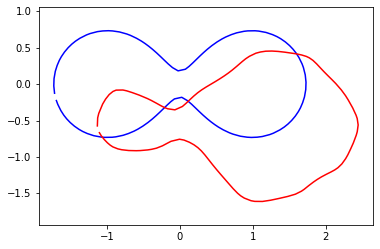

In [3]:
plt.plot(source[:,0].detach(), source[:,1].detach(), '-b')
plt.plot(target[:,0].detach(), target[:,1].detach(), '-r')
plt.axis('equal')
plt.show()

In [4]:
source0 = source
source1 = source + torch.ones(len(source),1) * torch.tensor([[1.5, 2]])

target0 = -target + torch.ones(len(target),1) * torch.tensor([[0, 0]])
target1 = target + torch.ones(len(target),1) * torch.tensor([[1.5, 2.5]])

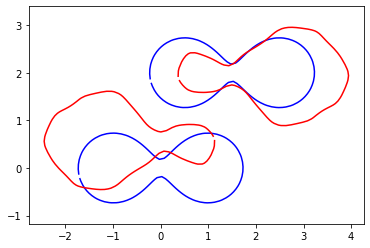

In [5]:
plt.plot(source0[:,0].detach(), source0[:,1].detach(), '-b')
plt.plot(source1[:,0].detach(), source1[:,1].detach(), '-b')
plt.plot(target0[:,0].detach(), target0[:,1].detach(), '-r')
plt.plot(target1[:,0].detach(), target1[:,1].detach(), '-r')
plt.axis('equal')
plt.show()

In [6]:
boundary0 = dm.MultiShape.Boundary(source0)
boundary1 = dm.MultiShape.Boundary(source1)

source_deformable0 = dm.Models.DeformablePoints(source0)
source_deformable1 = dm.Models.DeformablePoints(source1)
target_deformable0 = dm.Models.DeformablePoints(target0)
target_deformable1 = dm.Models.DeformablePoints(target1)

scale_scaling = 1.
scaling00 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[-1,0]], dtype=torch.float64, requires_grad=True))
scaling01 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[1,0]], dtype=torch.float64, requires_grad=True))
scaling10 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[0.5,2]], dtype=torch.float64, requires_grad=True))
scaling11 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[2.5,2]], dtype=torch.float64, requires_grad=True))

scale_translation = 1.
translation0 = translation = dm.DeformationModules.GlobalTranslation(2)
translation1 = translation = dm.DeformationModules.GlobalTranslation(2)


compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold(
    [dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), scaling00.manifold.clone(requires_grad=True), scaling01.manifold.clone(requires_grad=True), translation0.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), scaling10.manifold.clone(requires_grad=True), scaling11.manifold.clone(requires_grad=True), translation1.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)])])
sigma_bck = 0.5


attach = dm.Attachment.EuclideanPointwiseDistanceAttachment()

shoot_solver = 'torch_euler'
shoot_it = 10

constraints0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man)
constraints1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man)
constraints = dm.Constraints.Constraints.CompoundConstraints([constraints0, constraints1])

model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable0, source_deformable1], [[scaling00, scaling01, translation0], [scaling10, scaling11, translation1]], [attach, attach], sigma_bck, lam=10., constraints=constraints)
multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, sigma_bck)

In [7]:
multishape.manifold.fill_gd(model.init_manifold.gd)
multishape.manifold.fill_cotan(model.init_manifold.cotan)
Ham = MultiShapeHamiltonian.Hamiltonian_multishape(multishape, constraints)


In [ ]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable0, target_deformable1], 40, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})